## BMENE4460 Final Project
### Eugénie Dulout & Antoine Andurao

**VGG and Transformers with 3 slices at a time**

This notebook contains our experiments with Transfer Learning on VGG11, SwinT and ViT.

In this file, the input to each model was a [3, 224, 224] Tensor, each channel being a different coronal slice from the same MRI.

In [ ]:
import numpy as np
import nibabel as nib
from torch.utils.data import Dataset
from glob import glob
import torch
from tqdm import tqdm
from skimage.measure import label, regionprops
from skimage import exposure
from scipy.ndimage.morphology import binary_fill_holes

# set random seed
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Train Dataset
class MRIDataset(Dataset):
    def __init__(self, paths, mode, slices_index, step, transform=None):
        print('***************')
        print('MRIDataset')
        self.images = []
        self.labels = []
        self.paths = paths
        print(f'Load T1. Total T1 {mode} number is: ' + str(len(self.paths)))

        self.transform = transform

        AD_count = 0
        CN_count = 0

        for path in tqdm(self.paths, total=len(self.paths), desc="Loading Nifti images, and getting slices"):

          label = path.split('/')[-2]
          label = (1 if label == 'AD' else 0)

          current_T1 = None
          T1_dimension = (182, 218, 182)

          current_T1 = nib.load(path).get_fdata().astype(np.float32)

          current_T1 = current_T1 / current_T1.max()


          for j in range(slices_index[0], slices_index[-1]+1, step):
              slice1 = current_T1[:,j,:]
              slice2 = current_T1[:,j+1,:]
              slice3 = current_T1[:,j+2,:]

              if self.transform:
                slice1 = self.transform(slice1).squeeze()
                slice2 = self.transform(slice2).squeeze()
                slice3 = self.transform(slice3).squeeze()

              self.images.append(torch.stack([slice1, slice2, slice3]))
              self.labels.append(label)

        print(f'Total loaded slices: {str(len(self.images))}')

    def __len__(self):

        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

class CLAHE():
    def __init__(self, clip_limit=0.02, tile_grid_size=(8, 8)):
        """
        Initialize CLAHE parameters.
        :param clip_limit: Threshold for contrast limiting.
        :param tile_grid_size: Size of the grid for the histogram equalization.
        """
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

    def __call__(self, img):
        """
        Apply CLAHE to a torch Tensor image.
        :param img: The input image torch Tensor.
        :return: Image after CLAHE as a torch Tensor.
        """
        # Ensure the image tensor is on CPU and convert it to numpy
        if isinstance(img, torch.Tensor):
            img = img.cpu()

        img_np = img.numpy()

        # Normalize the image data to [0, 1] for processing with skimage
        img_min = img_np.min()
        img_max = img_np.max()
        img_np = (img_np - img_min) / (img_max - img_min)

        # Apply CLAHE
        if img_np.ndim == 3:
            img_np = img_np[0]  # Remove channel dimension for processing

        clahe = exposure.equalize_adapthist(
            img_np,
            clip_limit=self.clip_limit,
            nbins=256,
            kernel_size=self.tile_grid_size
        )

        # Rescale back to the original range
        clahe = clahe * (img_max - img_min) + img_min

        # Convert back to a tensor
        clahe_tensor = torch.from_numpy(clahe).float()

        # Re-add the channel dimension if it was initially present
        if img.ndim == 3:
            clahe_tensor = clahe_tensor.unsqueeze(0)

        return clahe_tensor

<ipython-input-1-b2ab4710acc9>:9: DeprecationWarning: Please use `binary_fill_holes` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_fill_holes


In [ ]:
import os
import time
import numpy as np

import torch
from torch import optim
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
from torch.nn.utils import clip_grad_value_
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import roc_curve, auc
import scipy

In [ ]:
# Transform pipeline using torchvision
transforms_pipeline_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    CLAHE(),
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.5, 0.5))
])

In [ ]:
def filter_paths(n_patients, paths):
    AD_count, CN_count = 0, 0
    filtered_paths = []
    for idx in range(len(paths)):

              label = paths[idx].split('/')[-2]
              label = (1 if label == 'AD' else 0)

              if AD_count>=n_patients and CN_count>=n_patients:
                break
              elif label == 1:
                if AD_count>=n_patients:
                  continue
                else:
                  filtered_paths.append(paths[idx])
                  AD_count += 1
              else:
                if CN_count>=n_patients:
                  continue
                else:
                  filtered_paths.append(paths[idx])
                  CN_count += 1
    return filtered_paths

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
main_path = "/content/drive/My Drive/BMENE4460/Final Project/"

# define dataset dir
TrainDataDir = main_path + 'ADNI_large_sample/train/'
ValidationDataDir = main_path + 'ADNI_large_sample/validation/'

train_paths = filter_paths(500, sorted(glob(TrainDataDir + 'T1_affine/*/*.nii.gz')))
val_paths = filter_paths(100, sorted(glob(ValidationDataDir + 'T1_affine/*/*.nii.gz')))

# Parameters to change
batch_size = 3
start_slice = 99
stop_slice = 101


# Train
Train_MRIDataset = MRIDataset(train_paths, slices_index=[i for i in range(start_slice, stop_slice)], step=3, mode = 'train', transform=transforms_pipeline_train)
Train_dataloader = DataLoader(Train_MRIDataset, batch_size = batch_size,
                        shuffle=True, num_workers=0)


# Validation
Validation_MRIDataset = MRIDataset(val_paths, slices_index=[i for i in range(start_slice, stop_slice)], step=3, mode = 'validation', transform=transforms_pipeline_train)

Val_dataloader = DataLoader(Validation_MRIDataset, batch_size = batch_size,
                        shuffle=True, num_workers=0)


***************
MRIDataset
Load T1. Total T1 train number is: 1000


Loading Nifti images, and getting slices: 100%|██████████| 1000/1000 [09:16<00:00,  1.80it/s]


Total loaded slices: 1000
***************
MRIDataset
Load T1. Total T1 validation number is: 200


Loading Nifti images, and getting slices: 100%|██████████| 200/200 [03:30<00:00,  1.05s/it]

Total loaded slices: 200


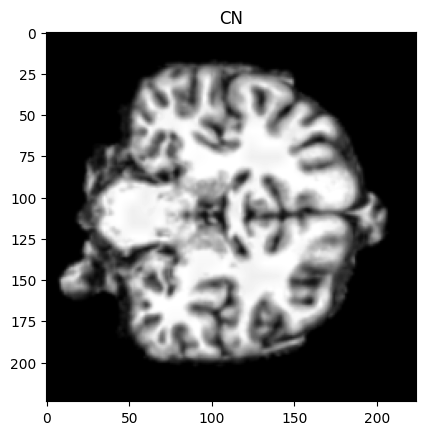

In [ ]:
import matplotlib.pyplot as plt

i = np.random.randint(len(Train_MRIDataset))
sample_T1 = Train_MRIDataset[i][0].cpu().numpy()
plt.imshow(sample_T1[0,:,:], cmap='gray')
plt.title("AD" if Train_MRIDataset[i][1]==1 else 'CN')
plt.show()

In [ ]:
save_dir = main_path + "/saved_models/"
if not os.path.exists(save_dir):
  os.mkdir(save_dir)

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, roc_curve, auc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")  # Outputs the device being used

def compute_heatmap(model, image):
    model.eval()
    image = image.to(device)
    image.requires_grad = True
    with torch.set_grad_enabled(True):
        output = model(image.unsqueeze(0))
        predicted_class = torch.argmax(output, dim=1)
        model.vgg.classifier[6].weight.grad = None
        output[:, predicted_class].backward()

        heatmap = image.grad.squeeze().abs().detach().cpu().numpy()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)
    return heatmap

def plot_heatmap(image, heatmap, title):
    plt.imshow(image.squeeze(), cmap='gray')
    plt.imshow(heatmap, alpha=0.6, cmap='jet')
    plt.colorbar()
    plt.title(title)
    plt.axis('off')
    plt.show()

def train(model, train_loader, val_loader, optimizer, criterion, device, save_dir, model_name="", epochs=10, patience=5):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)  # Ensure the save directory exists

    train_losses = []
    val_losses = []
    accuracies = []

    best_val_acc = 0
    best_epoch = 0
    epochs_no_improve = 0

    # Define the learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        predictions = []
        true_labels = []

        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            with torch.no_grad():
                output = model(images)
                loss = criterion(output, labels)
                val_loss += loss.item() * images.size(0)

                predicted_labels = torch.argmax(output, dim=1)
                predictions.extend(predicted_labels.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        accuracy = accuracy_score(true_labels, predictions)
        accuracies.append(accuracy)

        scheduler.step(val_loss)

        print(f"Epoch {epoch}/{epochs}:")
        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")

        if accuracy > best_val_acc:
            best_val_acc = accuracy

            if os.path.exists(os.path.join(save_dir, f'{model_name}_epoch_{best_epoch}.pt')):
              os.remove(os.path.join(save_dir, f'{model_name}_epoch_{best_epoch}.pt'))
            # Save the model
            model_path = os.path.join(save_dir, f'{model_name}_epoch_{epoch}.pt')
            torch.save(model.state_dict(), model_path)

            best_epoch = epoch
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print("Early stopping triggered")
            break

    # Plot loss and validation curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    return best_epoch

Running on: cuda


In [ ]:
# define dataset dir
TestDataDir = main_path + 'ADNI_large_sample/test/'

test_paths = filter_paths(100, sorted(glob(TestDataDir + 'T1_affine/*/*.nii.gz')))

# Parameters to change
batch_size = 3
start_slice = 99
stop_slice = 101

# Train
Test_MRIDataset = MRIDataset(test_paths, slices_index=[i for i in range(start_slice, stop_slice)], step=3, mode = 'test', transform=transforms_pipeline_train)
Test_dataloader = DataLoader(Test_MRIDataset, batch_size = batch_size,
                        shuffle=True, num_workers=0)

***************
MRIDataset
Load T1. Total T1 test number is: 200


Loading Nifti images, and getting slices: 100%|██████████| 200/200 [02:18<00:00,  1.44it/s]

Total loaded slices: 200


In [ ]:
def load_by_epoch(model, model_name, save_dir, best_epoch, device):
  # Construct the model file name based on the best_epoch
    model_filename = f'{model_name}_epoch_{best_epoch}.pt'
    model_path = os.path.join(save_dir, model_filename)

    # Check if the model file exists
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"No model found for best_epoch {best_epoch} at {model_path}")

    # Load the model
    model.load_state_dict(torch.load(model_path))
    model.to(device)

    return model

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns  # Ensure seaborn is installed for better visualization

def cm_and_acc(model, test_loader, device):

    # Evaluate the model
    model.eval()  # Set the model to evaluation mode
    true_labels = []
    predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)

    # Compute the confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    labels = sorted(list(set(true_labels)))  # Get sorted list of classes

    # Plotting the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["CN", "AD"], yticklabels=["CN", "AD"])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # Display accuracy
    plt.figtext(0.5, 0.01, f'Accuracy: {accuracy * 100:.2f}%', ha='center', fontsize=12)
    plt.show()

    return accuracy

In [ ]:
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score, confusion_matrix

def calculate_specificity(y_true, y_pred):
    tn, fp, _, _ = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return specificity

def evaluate_model(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    y_pred = []
    y_true = []
    y_scores = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            _, predicted = torch.max(outputs, 1)
            # Assuming outputs are logits; apply sigmoid if needed
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs > 0.5).astype(np.int32)  # Threshold the probabilities to obtain binary predictions

            y_scores.extend(probs[:, 1])  # Store probabilities for AUC calculation
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    return y_true, y_pred, y_scores

## VGG11


In [ ]:
import torchvision.models as models

# Load pretrained VGG11 model
vgg11 = models.vgg11(weights=None)

# Freeze the features part of the model
for param in vgg11.features.parameters():
    param.requires_grad = False

# Modify the classifier
num_features = vgg11.classifier[6].in_features  # Get the number of input features to the last layer
vgg11.classifier[6] = nn.Linear(num_features, 2)  # Replace the last layer

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg11 = vgg11.to(device)

# Define the optimizer and loss function
optimizer = torch.optim.Adam(vgg11.classifier.parameters(), lr=0.0001)  # Optimize only the classifier
criterion = nn.CrossEntropyLoss()

Epoch 1/25:
Train Loss: 0.7207, Val Loss: 0.7287, Accuracy: 0.5000
Epoch 2/25:
Train Loss: 0.6934, Val Loss: 0.7134, Accuracy: 0.5000
Epoch 3/25:
Train Loss: 0.6898, Val Loss: 0.6909, Accuracy: 0.5000
Epoch 4/25:
Train Loss: 0.6887, Val Loss: 0.6839, Accuracy: 0.5000
Epoch 5/25:
Train Loss: 0.6797, Val Loss: 0.6745, Accuracy: 0.6700
Epoch 6/25:
Train Loss: 0.6711, Val Loss: 0.6667, Accuracy: 0.6950
Epoch 7/25:
Train Loss: 0.6475, Val Loss: 0.6609, Accuracy: 0.5950
Epoch 8/25:
Train Loss: 0.6196, Val Loss: 0.6255, Accuracy: 0.6300
Epoch 9/25:
Train Loss: 0.5818, Val Loss: 0.6111, Accuracy: 0.6550
Epoch 10/25:
Train Loss: 0.5424, Val Loss: 0.6307, Accuracy: 0.6500
Epoch 11/25:
Train Loss: 0.5102, Val Loss: 0.5904, Accuracy: 0.6250
Epoch 12/25:
Train Loss: 0.5017, Val Loss: 0.5919, Accuracy: 0.6400
Epoch 13/25:
Train Loss: 0.4465, Val Loss: 0.5772, Accuracy: 0.6400
Epoch 14/25:
Train Loss: 0.4069, Val Loss: 0.6109, Accuracy: 0.6600
Epoch 15/25:
Train Loss: 0.4146, Val Loss: 0.5725, Accura

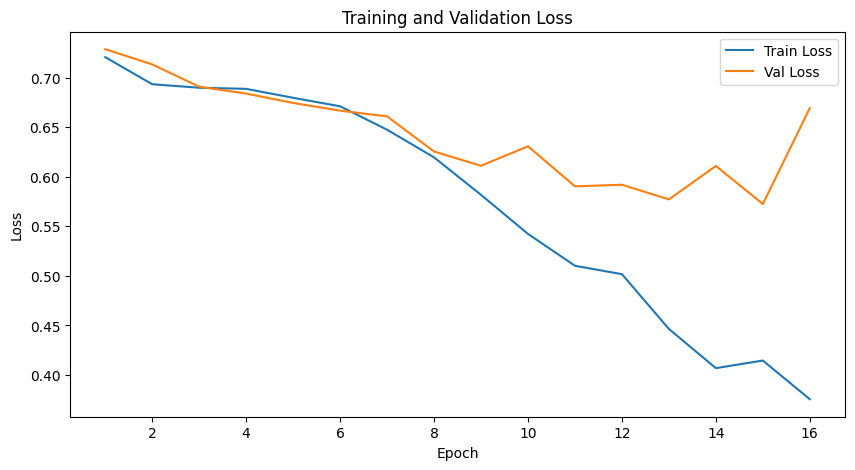

Training ended, best epoch is 6


In [ ]:
# Train the model
best_epoch = train(vgg11, Train_dataloader, Val_dataloader, optimizer, criterion, device, save_dir, model_name="vgg11_3x3_scratch", epochs=25, patience=10)
print(f"Training ended, best epoch is {best_epoch}")

In [ ]:
vgg11 = load_by_epoch(vgg11, "vgg11_3x3_scratch", save_dir, best_epoch, device)

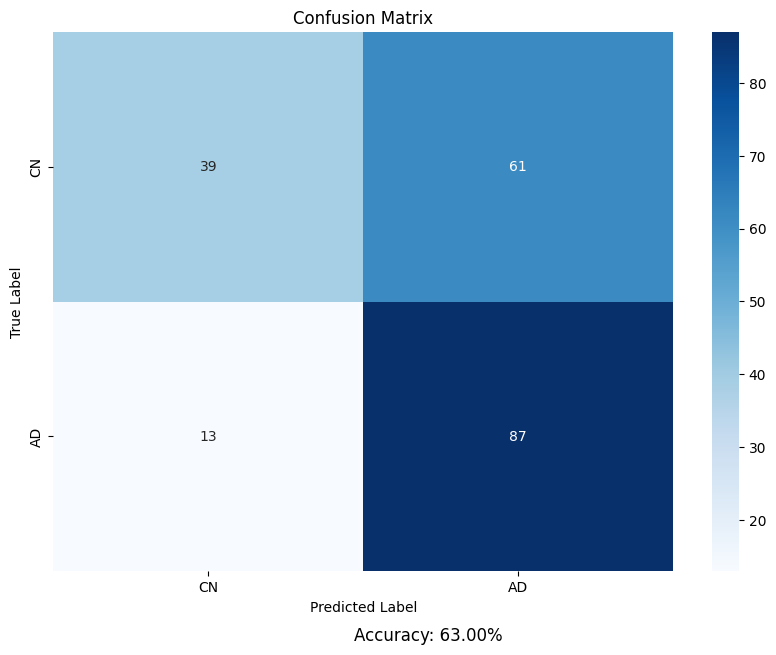

In [ ]:
accuracy = cm_and_acc(vgg11, Test_dataloader, device)

In [ ]:
y_true, y_pred, y_scores = evaluate_model(vgg11, Test_dataloader)

In [ ]:
auc = roc_auc_score(y_true, y_scores)
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
specificity = calculate_specificity(y_true, y_pred)

print(f'AUC: {auc}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')
print(f'Specificity: {specificity}')

AUC: 0.63
Recall: 0.87
Precision: 0.5878378378378378
F1 Score: 0.7016129032258064
Specificity: 0.39


## SwinT

In [ ]:
from torchvision.models import swin_t, Swin_T_Weights
class SwinT(nn.Module):
  def __init__(self):
    super(SwinT, self).__init__()
    self.model1 = swin_t(weights=Swin_T_Weights.IMAGENET1K_V1)

    self.fc1 = nn.Linear(1000, 2)

  def forward(self, x):
     x = self.model1(x)
     x = self.fc1(x)
     return x

In [ ]:
# Load pretrained Swin Transformer
swint = SwinT()

# Freeze all layers in the model
for param in swint.model1.parameters():
    param.requires_grad = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
swint = swint.to(device)

# Optimize only the classifier
optimizer = optim.Adam(swint.fc1.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

Epoch 1/40:
Train Loss: 0.7210, Val Loss: 0.6778, Accuracy: 0.6300
Epoch 2/40:
Train Loss: 0.6999, Val Loss: 0.6680, Accuracy: 0.6250
Epoch 3/40:
Train Loss: 0.7053, Val Loss: 0.6596, Accuracy: 0.6400
Epoch 4/40:
Train Loss: 0.6995, Val Loss: 0.6544, Accuracy: 0.6600
Epoch 5/40:
Train Loss: 0.6955, Val Loss: 0.6495, Accuracy: 0.6650
Epoch 6/40:
Train Loss: 0.6804, Val Loss: 0.6446, Accuracy: 0.6850
Epoch 7/40:
Train Loss: 0.6901, Val Loss: 0.6422, Accuracy: 0.6750
Epoch 8/40:
Train Loss: 0.6844, Val Loss: 0.6335, Accuracy: 0.7050
Epoch 9/40:
Train Loss: 0.6775, Val Loss: 0.6304, Accuracy: 0.7000
Epoch 10/40:
Train Loss: 0.6727, Val Loss: 0.6279, Accuracy: 0.7100
Epoch 11/40:
Train Loss: 0.6669, Val Loss: 0.6243, Accuracy: 0.7100
Epoch 12/40:
Train Loss: 0.6681, Val Loss: 0.6217, Accuracy: 0.7500
Epoch 13/40:
Train Loss: 0.6682, Val Loss: 0.6207, Accuracy: 0.7250
Epoch 14/40:
Train Loss: 0.6632, Val Loss: 0.6165, Accuracy: 0.7300
Epoch 15/40:
Train Loss: 0.6539, Val Loss: 0.6141, Accura

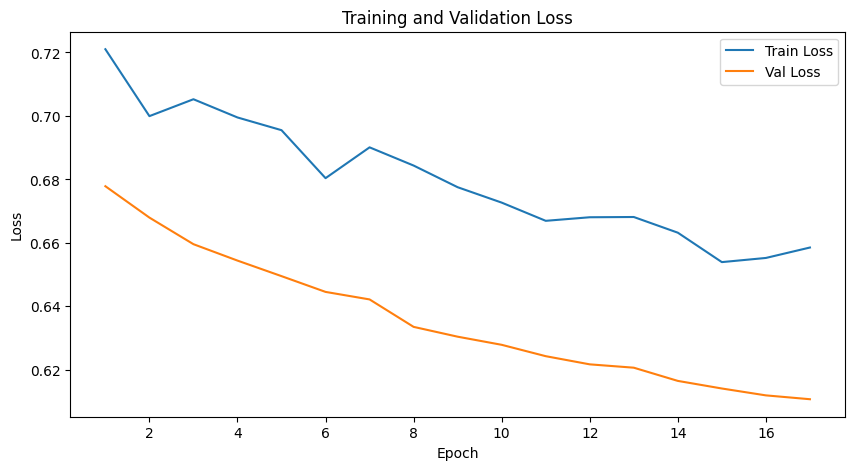

In [ ]:
# Train the model
best_epoch = train(swint, Train_dataloader, Val_dataloader, optimizer, criterion, device, save_dir, model_name="swint_3x3", epochs=40, patience=5)

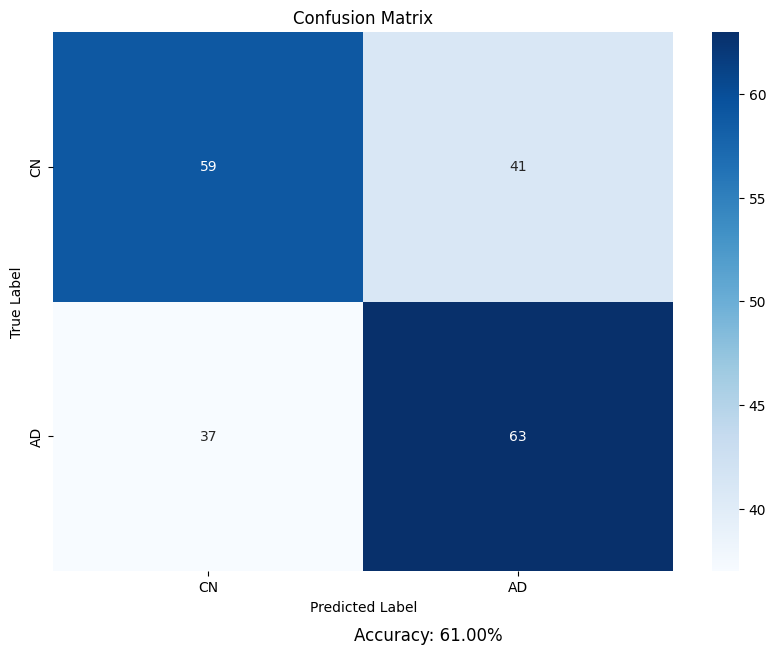

In [ ]:
accuracy = load_and_evaluate_by_epoch(swint, "swint_3x3", save_dir, 12, Test_dataloader, device)

In [ ]:
y_true, y_pred, y_scores = evaluate_model(swint, Test_dataloader)

In [ ]:
auc = roc_auc_score(y_true, y_scores)
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
specificity = calculate_specificity(y_true, y_pred)

print(f'AUC: {auc}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')
print(f'Specificity: {specificity}')

AUC: 0.7166
Recall: 0.63
Precision: 0.6057692307692307
F1 Score: 0.6176470588235293
Specificity: 0.59


## ViT

In [ ]:
!pip install timm

In [ ]:
import timm

class ViT(nn.Module):
    def __init__(self, num_classes=2):
        super(ViT, self).__init__()
        self.backbone = timm.create_model('vit_base_patch16_224', pretrained=True)
        self.backbone.head = nn.Linear(self.backbone.head.in_features, num_classes)

    def forward(self, x):
        x = self.backbone(x)
        return x

In [ ]:
ViT = ViT().to(device)

In [ ]:
# Freeze the features part of the model
for param in ViT.backbone.parameters():
    param.requires_grad = False
for param in ViT.backbone.head.parameters():
    param.requires_grad = True

# Optimize only the classifier
optimizer = optim.Adam(ViT.backbone.head.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

Epoch 1/40:
Train Loss: 0.7254, Val Loss: 0.6901, Accuracy: 0.5050
Epoch 2/40:
Train Loss: 0.7037, Val Loss: 0.6784, Accuracy: 0.5400
Epoch 3/40:
Train Loss: 0.6912, Val Loss: 0.6693, Accuracy: 0.5800
Epoch 4/40:
Train Loss: 0.6795, Val Loss: 0.6631, Accuracy: 0.6200
Epoch 5/40:
Train Loss: 0.6719, Val Loss: 0.6553, Accuracy: 0.6050
Epoch 6/40:
Train Loss: 0.6627, Val Loss: 0.6510, Accuracy: 0.6150
Epoch 7/40:
Train Loss: 0.6547, Val Loss: 0.6463, Accuracy: 0.6200
Epoch 8/40:
Train Loss: 0.6491, Val Loss: 0.6417, Accuracy: 0.6300
Epoch 9/40:
Train Loss: 0.6430, Val Loss: 0.6393, Accuracy: 0.6200
Epoch 10/40:
Train Loss: 0.6371, Val Loss: 0.6365, Accuracy: 0.6200
Epoch 11/40:
Train Loss: 0.6329, Val Loss: 0.6355, Accuracy: 0.6250
Epoch 12/40:
Train Loss: 0.6279, Val Loss: 0.6314, Accuracy: 0.6500
Epoch 13/40:
Train Loss: 0.6232, Val Loss: 0.6302, Accuracy: 0.6300
Epoch 14/40:
Train Loss: 0.6190, Val Loss: 0.6290, Accuracy: 0.6300
Epoch 15/40:
Train Loss: 0.6150, Val Loss: 0.6262, Accura

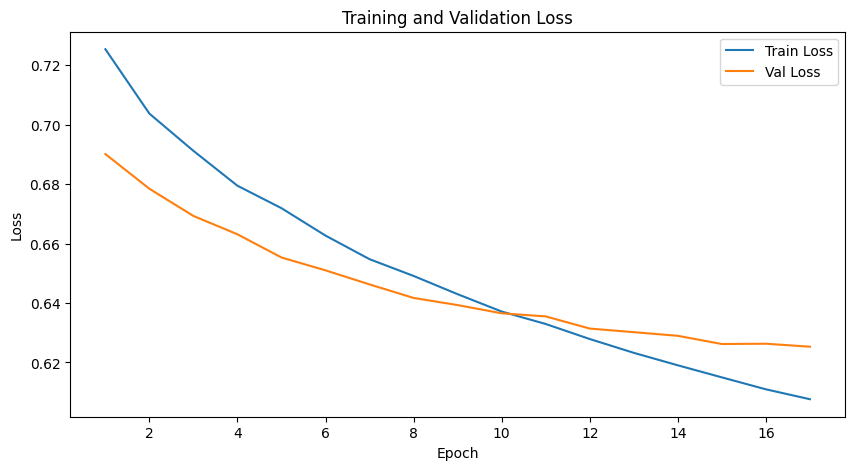

In [ ]:
# Train the model
best_epoch = train(ViT, Train_dataloader, Val_dataloader, optimizer, criterion, device, save_dir, model_name="ViT_3x3", epochs=40, patience=5)

In [ ]:
ViT = load_by_epoch(ViT, "ViT_3x3", save_dir, best_epoch, device)

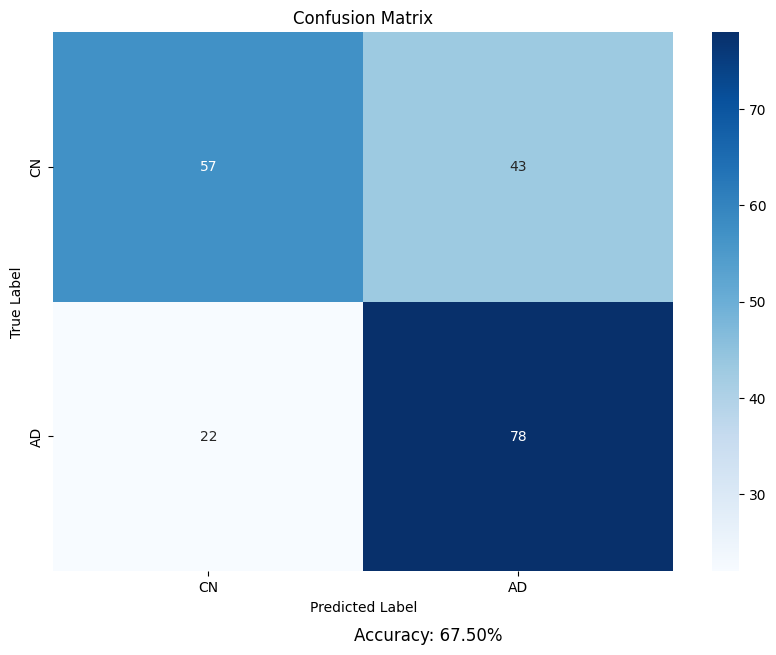

In [ ]:
accuracy = cm_and_acc(ViT, Test_dataloader, device)

In [ ]:
y_true, y_pred, y_scores = evaluate_model(ViT, Test_dataloader)

In [ ]:
auc = roc_auc_score(y_true, y_scores)
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
specificity = calculate_specificity(y_true, y_pred)

print(f'AUC: {auc}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')
print(f'Specificity: {specificity}')

AUC: 0.5679000000000001
Recall: 0.78
Precision: 0.6446280991735537
F1 Score: 0.7058823529411764
Specificity: 0.57
